# Import Libraries

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
import torchvision.transforms as transforms
from torchsummary import summary

from skimage import io
from torchvision.io import read_image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch import nn
from PIL import Image


from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [ ]:
!mkdir /content/dataset
%cd /content/dataset
!gdown 1B5XxZH2d5xdmEF93ECn4v2zZFHIcJJr0
!gdown 1v948L_w30H7Ga8xQLaxW_9CqavHPF2Bh

!unzip /content/dataset/train.zip
!unzip /content/dataset/test.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg     

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.csv_frame.iloc[idx, 0])
        img_array = cv2.imread(img_name)
        new_img_array = cv2.resize(img_array, dsize=(224, 224))
        label = self.csv_frame.iloc[idx, 1:]
        label = np.array(label, dtype = int)
        if self.transform:
            new_img_array = self.transform(new_img_array)
        sample = (new_img_array, label)

        return sample

In [ ]:
label_to_num = {
    'cat' : 0,
    'dog' : 1
}

In [ ]:
image_labels = []
image_paths = []

for filename in os.listdir('/content/dataset/train'):
  image_labels.append(label_to_num[filename.split('.')[0]])
  image_paths.append(filename)

data = pd.DataFrame({
    'image_path' : image_paths,
    'label' : image_labels
})

cat_df = data[data['label'] == 0]
dog_df = data[data['label'] == 1]


train_data = pd.concat([cat_df.iloc[ : int(cat_df.shape[0] * 0.8), : ], dog_df.iloc[ : int(dog_df.shape[0] * 0.8), : ]], ignore_index = True)
test_data = pd.concat([cat_df.iloc[int(cat_df.shape[0] * 0.8) : , : ], dog_df.iloc[int(dog_df.shape[0] * 0.8) : , : ]], ignore_index = True)

train_data.to_csv('/content/train.csv', index = False)
test_data.to_csv('/content/test.csv', index = False)

In [ ]:
train_dataset = CustomImageDataset(csv_file = '/content/train.csv',
                                    root_dir = '/content/dataset/train/',
                                    transform = transforms.ToTensor())

test_dataset = CustomImageDataset(csv_file = '/content/train.csv',
                                    root_dir = '/content/dataset/train/',
                                    transform = transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 0)

test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers = 0)

In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1]))

In [ ]:
def get_max ( data ) :
 max_value = data [0]

 # ########### Your code here
 for i in range(len(data)):
  if data[i] > max_value:
    max_value = data[i]
 # ###########

 return max_value

data1 = [1 , 5 , 2 , 91 , -10]
assert get_max ( data1 ) == 91

data2 = [1 , 5 , 2 , 91 , -10]
print ( get_max ( data2 ) )

91


# VGG16

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.csv_frame.iloc[idx, 0])
        img_array = cv2.imread(img_name)
        new_img_array = cv2.resize(img_array, dsize=(224, 224))
        label = self.csv_frame.iloc[idx, 1:]
        label = np.array(label, dtype = int)
        if self.transform:
            new_img_array = self.transform(new_img_array)
        sample = (new_img_array, label)

        return sample

In [ ]:
label_to_num = {
    'cat' : 0,
    'dog' : 1
}

In [ ]:
image_labels = []
image_paths = []

for filename in os.listdir('/content/dataset/train'):
  image_labels.append(label_to_num[filename.split('.')[0]])
  image_paths.append(filename)

data = pd.DataFrame({
    'image_path' : image_paths,
    'label' : image_labels
})

cat_df = data[data['label'] == 0]
dog_df = data[data['label'] == 1]


train_data = pd.concat([cat_df.iloc[ : int(cat_df.shape[0] * 0.8), : ], dog_df.iloc[ : int(dog_df.shape[0] * 0.8), : ]], ignore_index = True)
test_data = pd.concat([cat_df.iloc[int(cat_df.shape[0] * 0.8) : , : ], dog_df.iloc[int(dog_df.shape[0] * 0.8) : , : ]], ignore_index = True)

train_data.to_csv('/content/train.csv', index = False)
test_data.to_csv('/content/test.csv', index = False)

In [ ]:
train_dataset = CustomImageDataset(csv_file = '/content/train.csv',
                                    root_dir = '/content/dataset/train/',
                                    transform = transforms.ToTensor())

test_dataset = CustomImageDataset(csv_file = '/content/train.csv',
                                    root_dir = '/content/dataset/train/',
                                    transform = transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 0)

test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle = True, num_workers = 0)

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes = 10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7 * 7 * 512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
vgg16_model = VGG16(2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vgg16_model.parameters(), lr = 0.0001)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               epochs : int,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for epoch in range(epochs):
      start = time.time()
      for batch, (X, y) in enumerate(data_loader):
          # Send data to GPU
          X, y = X.to(device), y.squeeze().to(device)
          # 1. Forward pass
          y_pred = model(X)
          # 2. Calculate loss
          loss = loss_fn(y_pred, y)
          train_loss += loss
          train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1)) # Go from logits -> pred labels
          # 3. Optimizer zero grad
          optimizer.zero_grad()
          # 4. Loss backward
          loss.backward()
          # 5. Optimizer step
          optimizer.step()
      stop = time.time()
      # Calculate loss and accuracy per epoch and print out what's happening
      train_loss /= len(data_loader)
      train_acc /= len(data_loader)
      print(f"Epoch: {epoch + 1} | Training time: {stop - start}s | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.squeeze().to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y,
                y_pred = test_pred.argmax(dim = 1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
train_step(vgg16_model, train_dataloader, 15, loss_fn, optimizer, accuracy_fn)

OutOfMemoryError: ignored

In [ ]:
test_step(vgg16_model, test_dataloader, loss_fn, accuracy_fn)

# Neural Network

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Custom dataset class for handling images and corresponding labels.

        Args:
        - csv_file (string): Path to the CSV file containing image filenames and labels.
        - root_dir (string): Directory with all the images.
        - transform (callable, optional): Optional transform to be applied on images.
        """
        # Read the CSV file into a pandas DataFrame
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir  # Root directory containing images
        self.transform = transform  # Transformation to be applied on images

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.csv_frame)

    def __getitem__(self, idx):
        """
        Retrieves a sample and its corresponding label by index.

        Args:
        - idx (int): Index to retrieve the sample.

        Returns:
        - sample (tuple): A tuple containing the image and its label.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Fetch the image name based on the index
        img_name = os.path.join(self.root_dir, self.csv_frame.iloc[idx, 0])

        # Read the image using OpenCV
        img_array = cv2.imread(img_name)

        # Resize the image to a specific size (e.g., 32x32)
        new_img_array = cv2.resize(img_array, dsize=(32, 32))

        # Extract label information from the DataFrame and convert to NumPy array
        label = self.csv_frame.iloc[idx, 1:]
        label = np.array(label, dtype=int)

        # Apply transformation if specified
        if self.transform:
            new_img_array = self.transform(new_img_array)

        # Create a sample containing the image and its label as a tuple
        sample = (new_img_array, label)

        return sample


In [ ]:
label_to_num = {
    'cat' : 0,
    'dog' : 1
}

In [ ]:
# Creating a training dataset using CustomImageDataset
train_dataset = CustomImageDataset(
    csv_file='/content/train.csv',  # Path to the CSV file with image filenames and labels
    root_dir='/content/dataset/train/',  # Root directory containing training images
    transform=transforms.ToTensor()  # Transform to convert images to PyTorch tensors
)

# Creating a test/validation dataset using CustomImageDataset
test_dataset = CustomImageDataset(
    csv_file='/content/train.csv',  # Path to the CSV file with image filenames and labels
    root_dir='/content/dataset/train/',  # Root directory containing test/validation images
    transform=transforms.ToTensor()  # Transform to convert images to PyTorch tensors
)

# Creating a training dataloader using DataLoader
train_dataloader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=32,  # Number of samples per batch
    shuffle=True,  # Shuffle the data during training
    num_workers=0  # Number of subprocesses to use for data loading
)

# Creating a test/validation dataloader using DataLoader
test_dataloader = DataLoader(
    test_dataset,  # Test/validation dataset
    batch_size=32,  # Number of samples per batch
    shuffle=True,  # Shuffle the data during testing/validation
    num_workers=0  # Number of subprocesses to use for data loading
)


In [ ]:
# Initialize empty lists to store image labels and paths
image_labels = []
image_paths = []

# Loop through each file in the '/content/dataset/train' directory
for filename in os.listdir('/content/dataset/train'):
    # Extract the label using a dictionary 'label_to_num'
    image_labels.append(label_to_num[filename.split('.')[0]])  # Assuming label_to_num is a mapping of labels to numerical values
    image_paths.append(filename)  # Store the file path

# Create a DataFrame containing image paths and their corresponding labels
data = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

# Separate the DataFrame into categories (e.g., 'cat' and 'dog')
cat_df = data[data['label'] == 0]  # Assuming '0' represents the category 'cat'
dog_df = data[data['label'] == 1]  # Assuming '1' represents the category 'dog'

# Create training and test DataFrames by splitting data based on categories
# Concatenate 80% of cat_df and 80% of dog_df for training data
train_data = pd.concat([
    cat_df.iloc[:int(cat_df.shape[0] * 0.8), :],
    dog_df.iloc[:int(dog_df.shape[0] * 0.8), :]
], ignore_index=True)

# Concatenate the remaining 20% of cat_df and dog_df for test data
test_data = pd.concat([
    cat_df.iloc[int(cat_df.shape[0] * 0.8):, :],
    dog_df.iloc[int(dog_df.shape[0] * 0.8):, :]
], ignore_index=True)

# Save the training and test DataFrames to CSV files
train_data.to_csv('/content/train.csv', index=False)  # Save training data to 'train.csv'
test_data.to_csv('/content/test.csv', index=False)  # Save test data to 'test.csv'


In [ ]:
class Neural_Network(nn.Module):
  def __init__(self, input_shape, num_classes = 10):
    super(Neural_Network, self).__init__()
    self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = 1024 * 2),
            nn.ReLU(),
            nn.Linear(in_features = 1024 * 2, out_features = 1024),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = 864),
            nn.ReLU(),
            nn.Linear(in_features = 864, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 384),
            nn.ReLU(),
            nn.Linear(in_features = 384, out_features = 288),
            nn.ReLU(),
            nn.Linear(in_features = 288, out_features = 216),
            nn.ReLU(),
            nn.Linear(in_features = 216, out_features = 162),
            nn.ReLU(),
            nn.Linear(in_features = 162, out_features = 81),
            nn.ReLU(),
            nn.Linear(in_features = 81, out_features = 27),
            nn.ReLU(),
            nn.Linear(in_features = 27, out_features = 9),
            nn.ReLU(),
            nn.Linear(in_features = 9, out_features = num_classes)
        )
  def forward(self, x):
    x = self.layer_stack(x)
    return x

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               epochs: int,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0  # Initialize variables to store cumulative loss and accuracy
    model.to(device)  # Move the model to the specified device (GPU or CPU)

    for epoch in range(epochs):  # Iterate over the specified number of epochs
        start = time.time()  # Record the start time of the epoch
        for batch, (X, y) in enumerate(data_loader):  # Iterate through batches in the data_loader
            # Send data to GPU
            X, y = X.to(device), y.squeeze().to(device)

            # 1. Forward pass
            y_pred = model(X)  # Perform forward pass to get predictions

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)  # Calculate the loss using the specified loss function
            train_loss += loss.item()  # Accumulate the loss

            # Calculate accuracy
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Calculate accuracy for the batch

            # 3. Optimizer zero grad
            optimizer.zero_grad()  # Zero-out gradients from previous steps

            # 4. Loss backward
            loss.backward()  # Backpropagate the loss through the network

            # 5. Optimizer step
            optimizer.step()  # Update model parameters based on gradients

        stop = time.time()  # Record the end time of the epoch

        # Calculate average loss and accuracy per epoch
        train_loss /= len(data_loader)  # Average training loss across batches
        train_acc /= len(data_loader)  # Average training accuracy across batches

        # Print training statistics for the epoch
        print(f"Epoch: {epoch + 1} | Training time: {stop - start}s | Loss: {train_loss:.5f}, Accuracy: {train_acc * 100:.2f}%")


In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0  # Initialize variables to store cumulative loss and accuracy
    model.to(device)  # Move the model to the specified device (GPU or CPU)
    model.eval()  # Set the model to evaluation mode (no training)

    start = time.time()  # Record the start time for testing

    for X, y in data_loader:  # Iterate through batches in the data_loader
        # Send data to GPU
        X, y = X.to(device), y.squeeze().to(device)

        # 1. Forward pass (inference)
        test_pred = model(X)  # Perform forward pass to get predictions

        # 2. Calculate loss and accuracy
        test_loss += loss_fn(test_pred, y).item()  # Accumulate the test loss
        test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))  # Calculate accuracy for the batch

    # Calculate average loss and accuracy
    test_loss /= len(data_loader)  # Average test loss across batches
    test_acc /= len(data_loader)  # Average test accuracy across batches

    end = time.time()  # Record the end time for testing

    # Print test statistics
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc * 100:.2f}%")
    print(f"Total test time: {end - start:.2f} seconds\n")


In [ ]:
nn_model = Neural_Network(3 * 1024, 2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = nn_model.parameters(), lr = 0.001)

In [ ]:
train_step(nn_model, train_dataloader, 5, loss_fn, optimizer, accuracy_fn)

NameError: ignored

In [ ]:
test_step(nn_model, test_dataloader, loss_fn, accuracy_fn)

# VGG16 (Finetune)

In [ ]:
# Fetching filenames from the specified directory
filenames = os.listdir("/content/dataset/train")

# Initializing an empty list to store categories
categories = []

# Iterating through each filename
for filename in filenames:
    # Extracting the category from the filename
    category = filename.split('.')[0]
    # Checking if the category is 'dog', assigning 1 if True, else assigning 0
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

# Creating a DataFrame with filenames and their respective categories
df = pd.DataFrame({
                    'filename': filenames,
                    'category': categories
})

# Splitting the DataFrame into training and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Resetting the index of the training and validation DataFrames
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# Calculating the total number of samples in the training and validation sets
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [ ]:
# Defining the input shape for the model
image_size, batch_size = 224, 128

# Loading the VGG16 model with specified parameters
pre_trained_model = VGG16(input_shape = (224, 224, 3), include_top=False, weights="imagenet")

# Freezing the layers up to the 15th layer
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

# Unfreezing layers from the 15th layer onwards
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

# Retrieving the output of the last convolutional block
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension using GlobalMaxPooling
x = GlobalMaxPooling2D()(last_output)

# Adding a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Adding a dropout layer with a rate of 0.5 for regularization
x = Dropout(0.5)(x)

# Adding a final sigmoid layer for binary classification
x = layers.Dense(1, activation='sigmoid')(x)

# Creating the final model by specifying its input and output
model = Model(pre_trained_model.input, x)

# Compiling the model with specific loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Displaying a summary of the model architecture
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Defining an ImageDataGenerator for training data with various image augmentation techniques
ImageDataGenerator_Train = ImageDataGenerator(
    rotation_range=15,  # Rotate images randomly up to 15 degrees
    rescale=1./255,  # Rescale pixel values to be between 0 and 1
    shear_range=0.2,  # Apply shear-based transformations
    zoom_range=0.2,  # Apply random zoom to the images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill points outside the input boundary using the nearest value
    width_shift_range=0.1,  # Shift images horizontally
    height_shift_range=0.1  # Shift images vertically
)

# Creating a generator for training data using the defined ImageDataGenerator
Train_Generator = ImageDataGenerator_Train.flow_from_dataframe(
    train_df,  # Dataframe containing training data
    "/content/dataset/train",  # Path to the directory containing training images
    x_col='filename',  # Column name in the dataframe for image filenames
    y_col='category',  # Column name in the dataframe for image categories
    class_mode='raw',  # The output will be raw numerical values (categories)
    target_size=(image_size, image_size),  # Resizing images to the specified dimensions
    batch_size=batch_size  # Number of samples per batch during training
)

# Defining an ImageDataGenerator for test/validation data without augmentation
ImageDataGenerator_Validation = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to be between 0 and 1

# Creating a generator for test/validation data using the defined ImageDataGenerator
Validation_Generator = ImageDataGenerator_Validation.flow_from_dataframe(
    validate_df,  # Dataframe containing validation data
    "/content/dataset/train",  # Path to the directory containing validation images
    x_col='filename',  # Column name in the dataframe for image filenames
    y_col='category',  # Column name in the dataframe for image categories
    class_mode='raw',  # The output will be raw numerical values (categories)
    target_size=(image_size, image_size),  # Resizing images to the specified dimensions
    batch_size=batch_size  # Number of samples per batch during testing/validation
)


Found 20000 validated image filenames.
Found 5000 validated image filenames.


In [ ]:
# Fine-tuning the model by training with fit_generator
history = model.fit(
    Train_Generator,  # Training data generator
    epochs=3,  # Number of epochs for training
    validation_data=Validation_Generator,  # Validation data generator
    validation_steps=total_validate//batch_size,  # Number of steps (batches) to validate in each epoch
    steps_per_epoch=total_train//batch_size  # Number of steps (batches) to take in each epoch
)

Epoch 1/3
156/156 [==============================] - 352s 2s/step - loss: 0.6316 - accuracy: 0.6533 - val_loss: 0.3557 - val_accuracy: 0.8830
Epoch 2/3
156/156 [==============================] - 303s 2s/step - loss: 0.3746 - accuracy: 0.8338 - val_loss: 0.2314 - val_accuracy: 0.9103
Epoch 3/3
156/156 [==============================] - 304s 2s/step - loss: 0.2755 - accuracy: 0.8831 - val_loss: 0.1871 - val_accuracy: 0.9265


In [ ]:
loss, accuracy = model.evaluate_generator(Validation_Generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-23-7b077105b511>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(Validation_Generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.926883  ;  loss = 0.186507 


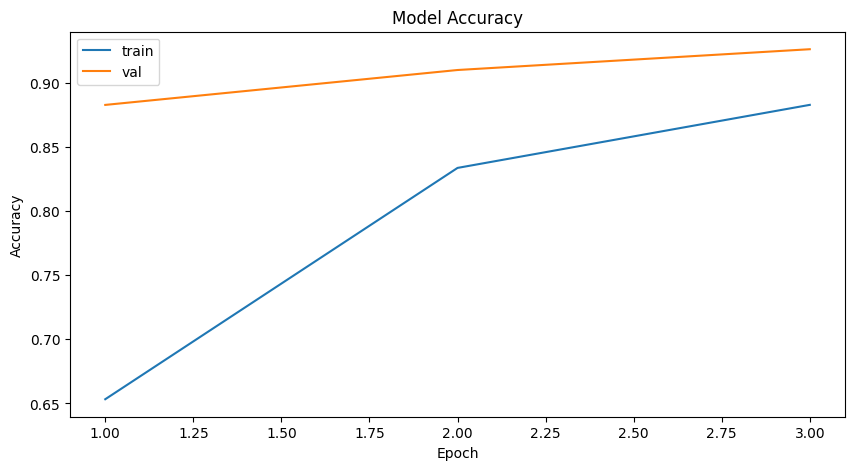

In [ ]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    plt.figure(figsize = (10, 5))
    plt.plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    plt.plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

# Model

## Random Forest

In [ ]:
import time

In [ ]:
def random_forest_classifier(X_train, y_train, X_test, y_test):
  rf = RandomForestClassifier() #$
  start_train = time.time()
  rf.fit(X_train, y_train) #$
  end_train = time.time()
  print("time to train: ",end_train-start_train)
  start_pred = time.time()
  y_pred = rf.predict(X_test) #$
  end_pred = time.time()
  print("time to predict: ",end_pred-start_pred)
  print("Acc: ",accuracy_score(y_test, y_pred))
  return

## SVM

In [ ]:
def SVM_classifier(X_train, y_train, X_test, y_test):
  svm = SVC(kernel="rbf", gamma = 0.5, C = 1.0)
  start_train = time.time()
  svm.fit(X_train, y_train)
  end_train = time.time()
  print("time to train: ",end_train-start_train)
  start_pred = time.time()
  y_pred = svm.predict(X_test)
  end_pred = time.time()
  print("time to predict: ",end_pred-start_pred)
  print("Acc: ",accuracy_score(y_test, y_pred))
  return

## Decision Tree

In [ ]:
def decision_tree_prediction(X_train, y_train, X_test, y_test):
  dcs_tree_classifier = DecisionTreeClassifier()
  start_train = time.time()
  dcs_tree_classifier.fit(X_train, y_train)
  end_train = time.time()
  print("time to train: ",end_train-start_train)
  start_pred = time.time()
  y_pred = dcs_tree_classifier.predict(X_test)
  end_pred = time.time()
  print("time to predict: ",end_pred-start_pred)
  print("Acc: ",accuracy_score(y_test, y_pred))
  return

## KNN

In [ ]:
def knn_prediction(X_train, y_train, X_test, y_test, n_neighbors = 2):
  # Scale the features using StandardScaler
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  knn_classifier = KNeighborsClassifier(n_neighbors = n_neighbors)
  start_train = time.time()
  knn_classifier.fit(X_train, y_train)
  end_train = time.time()
  print("time to train: ",end_train-start_train)
  start_pred = time.time()
  y_pred = knn_classifier.predict(X_test)
  end_pred = time.time()
  print("time to predict: ",end_pred-start_pred)
  print("Acc: ",accuracy_score(y_test, y_pred))
  return

# Test

In [ ]:
import cv2
import numpy as np

def extract_features(image):
    # Chuyển đổi hình ảnh sang không gian màu HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Tính trung bình của các kênh màu
    features = np.array([
        np.mean(img_hsv[:, :, 0]),
        np.mean(img_hsv[:, :, 1]),
        np.mean(img_hsv[:, :, 2])
    ])

    return features

# Trích xuất đặc trưng cho tập huấn luyện
features_train = []
for file in os.listdir('/content/dataset/train'):
    image = cv2.imread(os.path.join('/content/dataset/train', file))
    features = extract_features(image)
    features_train.append(features)



In [ ]:
features_train = np.array(features_train).reshape(-1,3)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


Train_pred=np.array(image_labels)
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra.
X_train, X_test, y_train, y_test = train_test_split(features_train, Train_pred, test_size=0.25)

In [ ]:
print(y_train)

[1 0 0 ... 0 1 0]


In [ ]:
print(sum(y_train==0))

9417


In [ ]:
print(sum(y_test==0))

3083


In [ ]:
random_forest_classifier(X_train, y_train, X_test, y_test)

time to train:  4.222554445266724
time to predict:  0.17577195167541504
Acc:  0.5464


In [ ]:
SVM_classifier(X_train, y_train, X_test, y_test)

time to train:  41.421963691711426
time to predict:  6.287741661071777
Acc:  0.51872


In [ ]:
decision_tree_prediction(X_train, y_train, X_test, y_test)

time to train:  0.11673188209533691
time to predict:  0.0019609928131103516
Acc:  0.52832


In [ ]:
knn_prediction(X_train, y_train, X_test, y_test, n_neighbors = 2)

time to train:  0.010344505310058594
time to predict:  0.38923168182373047
Acc:  0.51344
